<a href="https://colab.research.google.com/github/Hamouda-Yasmine/PFE-X-ray_image_search_using_CBIR_deepL/blob/main/interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun 20 21:40:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install torch-model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import  torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    #plt.imshow(slc.cpu(), cmap='hot')
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
from PIL import Image

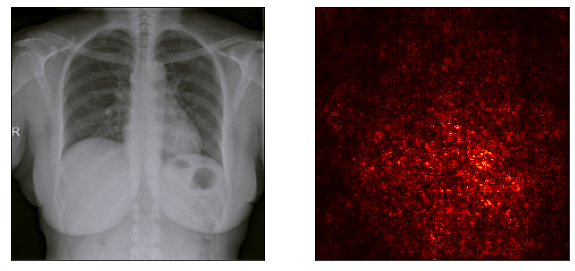

In [ ]:
img = Image.open('/content/drive/MyDrive/PFE/C_NC_N/1/covid_8.png').convert('RGB')
model = torchvision.models.resnet18(pretrained=True)
saliency(img, model)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision import models
from torchcam.methods import GradCAM
device='cuda'
"""ENCODER_MODEL_PATH = "/content/drive/MyDrive/IRMA/resnet18_54.pt"
model = models.resnet18()"""
# Load the state dict of encoder
#model.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
model = models.resnet18(pretrained=True).eval()
model.eval()
cam_extractor = GradCAM(model)
# Get your input
img = torchvision.io.read_image("/content/drive/MyDrive/PFE/C_NC_N/1/covid_8.png", mode=torchvision.io.image.ImageReadMode.RGB)

#img = torchvision.io.read_image("/content/drive/MyDrive/PFE/test-train/test/normal/Normal (8459).png", mode=torchvision.io.image.ImageReadMode.RGB)
#img = torchvision.io.read_image("/content/drive/MyDrive/IRMA/datatrainsplit/4/10019.png")
print(img.shape)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

torch.Size([3, 256, 256])


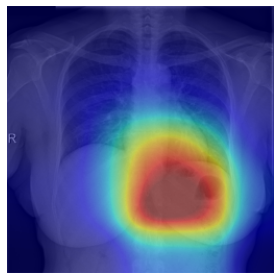

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
from torchcam.methods import GradCAM
device='cuda'
ENCODER_MODEL_PATH = "/content/drive/MyDrive/IRMA/resnet18_54.pt"
model = models.resnet18()
model.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
model.eval()
cam_extractor = GradCAM(model)
img = torchvision.io.read_image("/content/drive/MyDrive/IRMA/datatrainsplit/4/10019.png",
                                mode=torchvision.io.image.ImageReadMode.RGB)
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
cam_extractor = LayerCAM(model, ["layer1", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
for cam in cams:
  print(cam.shape)

In [ ]:
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch
import torchvision.transforms as T
import os
from sklearn.metrics import average_precision_score, accuracy_score,balanced_accuracy_score
from operator import is_not
from pathlib import Path
import pandas as pd
import csv
import os
import os.path
import cv2
import glob
import matplotlib.pyplot as plt
import shutil
import os
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        return x

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

ENCODER_MODEL_PATH = "/content/drive/MyDrive/IRMAcbirSGD/encoder_model_irmaSGD.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =ConvEncoder()
print (device)
# Load the state dict of encoder
model.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
# Initialize the model


# Set the model to run on the GPU

model = model.to(device)

# Set the model on Eval Mode
model.eval()

In [ ]:
from torchvision import transforms
from PIL import Image

# Open the image file
image = Image.open('/content/drive/MyDrive/PFE/C_NC_N/non_covid/non_COVID (1).png')

# Set up the transformations
transform_ = transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),

		transforms.ToTensor(),
])

# Transforms the image
image = transform_(image)
#image = image.reshape(1, 3, 224, 224)
image = image.to(device)
image.requires_grad_()


In [ ]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(torch.abs(image.grad[0]), dim=0)
saliency = saliency.reshape(224, 224)

# Reshape the image
image = image.reshape(-1, 224, 224)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [ ]:
from torchcam.methods import GradCAM
device='cuda'
ENCODER_MODEL_PATH = "/content/drive/MyDrive/IRMA/resnet18_54.pt"
model = models.resnet18()
model.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
model.eval()
cam_extractor = GradCAM(model)
img = torchvision.io.read_image("/content/drive/MyDrive/IRMA/datatrainsplit/4/10019.png",
                                mode=torchvision.io.image.ImageReadMode.RGB)
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()